## Load the data

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
import numpy as np


In [2]:
import os
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'data/datasets')
data_name = 'oqmd.csv'
data_path = os.path.join(data_dir, data_name)
df = pd.read_csv(data_path)

In [3]:
print('-'*25 + 'Data Info' + '-'*25)
print(df.head())
print('-'*25 + 'Data Info' + '-'*25)

-------------------------Data Info-------------------------
    formula  energy_per_atom  formation_energy_per_atom  band_gap  \
0  ZrZnNiMo        -6.399036                   0.157939       0.0   
1   DySc2Ir        -6.795189                  -0.266899       0.0   
2       YZr        -7.445319                   0.060478       0.0   
3   CrMoAu2        -6.218335                   0.504200       0.0   
4      Ge3O        -4.382844                   0.215750       0.0   

   magnetization_per_atom  
0                0.452473  
1                0.212367  
2                0.002801  
3                0.715628  
4                0.000000  
-------------------------Data Info-------------------------


In [4]:
data_size = df.shape[0]
print('Data size:', data_size)

Data size: 561888


In [5]:
df = df[:100000]

## Initialize Attribute Generators

In [6]:
# Process the data
# Use the Stoichoimetric Attribute, Ionicity Attribute, Elemental Property Attribute, and Charge Dependent Attribute as features
# Use bandgap, energy_pa, volume_pa, magmom_pa, fermi, hull_distance, and delta_e as targets

from generator import *

# Generate the features
stoichiometric_generator = StoichiometricAttributeGenerator()
ionicity_generator = IonicityAttributeGenerator()
elemental_generator = ElementalPropertyAttributeGenerator()
charge_generator = ChargeDependentAttributeGenerator()

## Prepare features and targets

In [7]:
from data.utils import CompositionEntry
from tqdm import tqdm

# Filter out rows where 'formula' is NaN
df_filtered = df.dropna(subset=['formula'])

# Print dropped rows
dropped_rows = data_size - df_filtered.shape[0]
print('-'*25 + 'Dropped Rows' + '-'*25)
print('Dropped rows:', dropped_rows)
print('-'*25 + 'Dropped Rows' + '-'*25)

print('-'*25 + 'Start: data processing' + '-'*25)
features = []
targets = []
for i in tqdm(range(len(df_filtered)), desc="Processing Formulas"):
    formula = df_filtered.iloc[i]['formula']
    if formula is float:
        continue
    entry = CompositionEntry(formula)
    stoichiometric = np.array(stoichiometric_generator.generate_features([entry])).flatten()
    ionicity = np.array(ionicity_generator.generate_features([entry])).flatten()
    elemental = np.array(elemental_generator.generate_features([entry])).flatten()
    # charge = np.array(charge_generator.generate_features([entry])).flatten()

    # filter all the nan values, if there is any, skip this entry
    if np.isnan(stoichiometric).any() or np.isnan(ionicity).any() or np.isnan(elemental).any():
        print('NaN values found in entry:', formula)
        continue
    
    # feature = np.concatenate([stoichiometric, ionicity, elemental, charge])
    feature = np.concatenate([stoichiometric, ionicity, elemental])
    targets.append(df_filtered.iloc[i][['energy_per_atom', 'formation_energy_per_atom', 'magnetization_per_atom']].values)
    features.append(feature)

print('-'*25 + 'Completed: data processing' + '-'*25)
features = np.array(features)
targets = np.array(targets)


-------------------------Dropped Rows-------------------------
Dropped rows: 461892
-------------------------Dropped Rows-------------------------
-------------------------Start: data processing-------------------------


Processing Formulas:   0%|          | 0/99996 [00:00<?, ?it/s]

Processing Formulas:  13%|█▎        | 12503/99996 [00:41<04:31, 322.36it/s]WARNING: There are 1 elemental properties with missing values: 
	Electronegativity: Ar
Processing Formulas:  13%|█▎        | 12569/99996 [00:41<04:35, 317.01it/s]

NaN values found in entry: Ar


Processing Formulas:  32%|███▏      | 31616/99996 [01:45<04:08, 275.66it/s]WARNING: There are 2 elemental properties with missing values: 
	MeltingT: He
	Electronegativity: He
Processing Formulas:  32%|███▏      | 31675/99996 [01:46<04:04, 279.97it/s]

NaN values found in entry: He


Processing Formulas:  37%|███▋      | 36719/99996 [02:02<03:17, 319.91it/s]WARNING: There are 1 elemental properties with missing values: 
	Electronegativity: Ne
Processing Formulas:  37%|███▋      | 36785/99996 [02:03<03:16, 321.15it/s]

NaN values found in entry: Ne


Processing Formulas:  47%|████▋     | 46980/99996 [02:35<02:50, 311.74it/s]WARNING: There are 1 elemental properties with missing values: 
	Electronegativity: Ar
Processing Formulas:  47%|████▋     | 47044/99996 [02:35<02:50, 310.01it/s]

NaN values found in entry: Ar


Processing Formulas:  56%|█████▌    | 55765/99996 [03:03<02:16, 322.86it/s]WARNING: There are 1 elemental properties with missing values: 
	Electronegativity: Ar
Processing Formulas:  56%|█████▌    | 55831/99996 [03:03<02:17, 320.69it/s]

NaN values found in entry: Ar


Processing Formulas:  57%|█████▋    | 57021/99996 [03:08<02:31, 283.89it/s]WARNING: There are 1 elemental properties with missing values: 
	Electronegativity: Ne
Processing Formulas:  57%|█████▋    | 57081/99996 [03:08<02:28, 289.53it/s]

NaN values found in entry: Ne


Processing Formulas:  58%|█████▊    | 58242/99996 [03:12<02:11, 318.54it/s]WARNING: There are 1 elemental properties with missing values: 
	Electronegativity: Ar
Processing Formulas:  58%|█████▊    | 58306/99996 [03:12<02:10, 318.76it/s]

NaN values found in entry: Ar


Processing Formulas:  72%|███████▏  | 72022/99996 [03:57<01:29, 311.00it/s]WARNING: There are 2 elemental properties with missing values: 
	MeltingT: He
	Electronegativity: He
Processing Formulas:  72%|███████▏  | 72085/99996 [03:57<01:31, 303.53it/s]

NaN values found in entry: He


Processing Formulas:  88%|████████▊ | 87504/99996 [04:48<00:40, 309.83it/s]WARNING: There are 1 elemental properties with missing values: 
	Electronegativity: Ne
Processing Formulas:  88%|████████▊ | 87567/99996 [04:49<00:40, 309.83it/s]

NaN values found in entry: Ne


Processing Formulas:  96%|█████████▌| 95946/99996 [05:16<00:13, 308.05it/s]WARNING: There are 1 elemental properties with missing values: 
	Electronegativity: Ar
Processing Formulas:  96%|█████████▌| 96009/99996 [05:17<00:12, 308.74it/s]

NaN values found in entry: Ar


Processing Formulas: 100%|██████████| 99996/99996 [05:29<00:00, 303.15it/s]


-------------------------Completed: data processing-------------------------


In [8]:
# from data.utils import CompositionEntry
# import numpy as np
# import pandas as pd
# # from concurrent.futures import ProcessPoolExecutor
# from concurrent.futures import ThreadPoolExecutor
# from tqdm import tqdm

# def generate_features_for_formula(formula):
#     if isinstance(formula, float):
#         return None
#     entry = CompositionEntry(formula)
#     stoichiometric = np.array(stoichiometric_generator.generate_features([entry])).flatten()
#     ionicity = np.array(ionicity_generator.generate_features([entry])).flatten()
#     elemental = np.array(elemental_generator.generate_features([entry])).flatten()
#     # charge = np.array(charge_generator.generate_features([entry])).flatten()

#     # filter all the nan values, if there is any, skip this entry
#     if np.isnan(stoichiometric).any() or np.isnan(ionicity).any() or np.isnan(elemental).any():
#         return None
    
#     # feature = np.concatenate([stoichiometric, ionicity, elemental, charge])
#     feature = np.concatenate([stoichiometric, ionicity, elemental])
#     return feature

# # Filter out rows where 'formula' is NaN
# df_filtered = df.dropna(subset=['formula'])

# # Print dropped rows
# dropped_rows = data_size - df_filtered.shape[0]
# print('-'*25 + 'Dropped Rows' + '-'*25)
# print('Dropped rows:', dropped_rows)
# print('-'*25 + 'Dropped Rows' + '-'*25)

# # Use ThreadPoolExecutor for parallel processing
# formulas = df_filtered['formula'].tolist()

# with ThreadPoolExecutor() as executor:
#     features = list(tqdm(executor.map(generate_features_for_formula, formulas), total=len(formulas)))

# # Filter out None values
# features = [f for f in features if f is not None]

# features = np.array(features)

In [9]:
print('-'*25 + 'Features' + '-'*25)
print("shape of features:", features.shape)
print(features[1])
print('-'*25 + 'Features' + '-'*25)

-------------------------Features-------------------------
shape of features: (99986, 141)
[3.00000000e+00 6.12372436e-01 5.38608673e-01 5.06099365e-01
 5.01108669e-01 5.00097571e-01 0.00000000e+00 2.13450798e-01
 6.83327026e-02 4.62500000e+01 5.60000000e+01 2.52500000e+01
 7.70000000e+01 2.10000000e+01 2.10000000e+01 2.82500000e+01
 4.90000000e+01 1.72500000e+01 6.00000000e+01 1.10000000e+01
 1.10000000e+01 1.11157206e+02 1.47261088e+02 6.62012940e+01
 1.92217000e+02 4.49559120e+01 4.49559120e+01 2.01300000e+03
 1.05400000e+03 3.63000000e+02 2.73900000e+03 1.68500000e+03
 1.81400000e+03 4.50000000e+00 6.00000000e+00 2.25000000e+00
 9.00000000e+00 3.00000000e+00 3.00000000e+00 5.00000000e+00
 2.00000000e+00 1.00000000e+00 6.00000000e+00 4.00000000e+00
 4.00000000e+00 1.68250000e+02 5.10000000e+01 1.36250000e+01
 1.92000000e+02 1.41000000e+02 1.70000000e+02 1.53500000e+00
 9.80000000e-01 3.32500000e-01 2.20000000e+00 1.22000000e+00
 1.36000000e+00 2.00000000e+00 0.00000000e+00 0.0000000

In [12]:
print('-'*25 + 'Targets' + '-'*25)
print("shape of features:", targets.shape)
print(targets[1])
print('-'*25 + 'Targets' + '-'*25)

-------------------------Targets-------------------------
shape of features: (99986, 3)
[-6.795188535 -0.266899046666668 0.21236685]
-------------------------Targets-------------------------


In [13]:
cur_dir = os.getcwd()
save_dir = os.path.join(cur_dir, 'data/datasets')
print('-'*25 + 'Saving Data' + '-'*25)
np.save(os.path.join(save_dir, 'features_OQMD_100k.npy'), features)
np.save(os.path.join(save_dir, 'targets_OQMD_100k.npy'), targets)
print('-'*25 + 'Data Saved' + '-'*25)

-------------------------Saving Data-------------------------
-------------------------Data Saved-------------------------


In [15]:
import random

# Convert features and targets to PyTorch tensors
features = torch.tensor(features, dtype=torch.float32)
targets = torch.tensor(targets.astype(np.float32), dtype=torch.float32)

# random_seed = random.randint(0, 1000)
random_seed = 1024

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=random_seed)

print('-'*25 + 'datasets information' + '-'*25)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(X_train[0])
print(y_train[0])
print('-'*25 + 'datasets information' + '-'*25)

-------------------------datasets information-------------------------
torch.Size([79988, 141]) torch.Size([79988, 3])
torch.Size([19998, 141]) torch.Size([19998, 3])
tensor([3.0000e+00, 5.7735e-01, 4.8075e-01, 4.1524e-01, 3.8998e-01, 3.7204e-01,
        0.0000e+00, 3.0161e-02, 1.0117e-02, 3.9333e+01, 5.7000e+01, 2.4222e+01,
        6.0000e+01, 3.0000e+00, 3.9333e+01, 8.3333e+00, 1.8000e+01, 7.1111e+00,
        1.9000e+01, 1.0000e+00, 8.3333e+00, 9.4696e+01, 1.3730e+02, 5.8503e+01,
        1.4424e+02, 6.9410e+00, 9.4696e+01, 6.8309e+02, 9.9241e+02, 4.0727e+02,
        1.2940e+03, 3.0159e+02, 6.8309e+02, 1.6667e+00, 2.0000e+00, 8.8889e-01,
        3.0000e+00, 1.0000e+00, 1.6667e+00, 4.6667e+00, 4.0000e+00, 1.7778e+00,
        6.0000e+00, 2.0000e+00, 4.6667e+00, 1.9100e+02, 1.1600e+02, 4.2000e+01,
        2.4400e+02, 1.2800e+02, 1.9100e+02, 9.7000e-01, 3.5000e-01, 1.2000e-01,
        1.1400e+00, 7.9000e-01, 9.7000e-01, 1.3333e+00, 1.0000e+00, 4.4444e-01,
        2.0000e+00, 1.0000e+00, 1

<ipython-input-15-57f29e54ca3a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float32)


In [16]:
# # Define the neural network architecture
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(X_train.shape[1], 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 32)
#         self.fc4 = nn.Linear(32, y_train.shape[1])
    
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = self.fc4(x)
#         return x

In [20]:
# from model.simple_model import Net
from model.simple_model_revised import Net
# from model.simple_model_residue import Net
# from model.model import Net
# from model.residue import Net

In [18]:
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# # Note this is the deprecated code

# # Initialize the model, loss function, and optimizer
# input_dim = X_train.shape[1]
# output_dim = y_train.shape[1]
# print("input dim {}, output dim {}".format(input_dim, output_dim))
# model = Net(input_dim, output_dim)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Train the model
# num_epochs = 1000
# losses = []
# for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
#     model.train()
#     optimizer.zero_grad()
#     outputs = model(X_train)
#     loss = criterion(outputs, y_train)
#     loss.backward()
#     optimizer.step()
    
#     losses.append(loss.item())

# # Evaluate the model
# model.eval()
# with torch.no_grad():
#     predictions = model(X_test)
#     mse = criterion(predictions, y_test).item()
#     print(f'Mean Squared Error: {mse}')

# # Save the trained model
# torch.save(model.state_dict(), cur_dir + '/model/' + 'OQMD_100k_model')

# # Plot the loss curve
# plt.figure(figsize=(10, 5))
# plt.plot(range(num_epochs), losses, label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss Curve')
# plt.legend()
# plt.show()


Using device: mps
input dim 141, output dim 3


Training Epochs: 100%|██████████| 1000/1000 [01:12<00:00, 13.79it/s]


Mean Squared Error: 0.4234520196914673


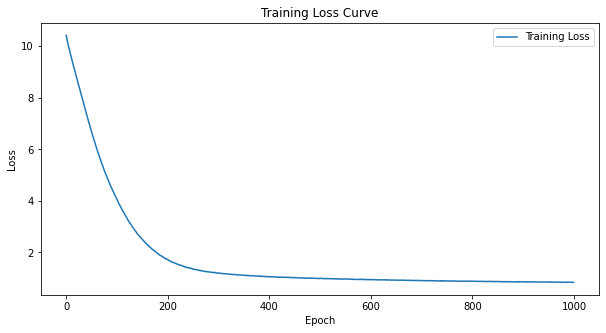

-------------------------Training Summary-------------------------
Mean Squared Error: 0.4234520196914673
-------------------------Training Summary-------------------------


In [21]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check if MPS is available and set the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Move data to the device
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
print("input dim {}, output dim {}".format(input_dim, output_dim))
model = Net(input_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 1000
losses = []
for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    # if (epoch+1) % 10 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mse = criterion(predictions, y_test).item()
    print(f'Mean Squared Error: {mse}')

# Save the trained model
torch.save(model.state_dict(), cur_dir + '/model/' + 'OQMD_100k_model')

# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

print('-'*25 + 'Training Summary' + '-'*25)
print(f'Mean Squared Error: {mse}')
print('-'*25 + 'Training Summary' + '-'*25)


In [57]:
# model = Net()
# model.load_state_dict(torch.load(current_dir + '/model/' + 'OQMD_100k_model'))

# # Make predictions
# model.eval()
# with torch.no_grad():
#     entry = CompositionEntry("Y2I6")
#     stoichiometric = np.array(stoichiometric_generator.generate_features([entry])).flatten()
#     ionicity = np.array(ionicity_generator.generate_features([entry])).flatten()
#     elemental = np.array(elemental_generator.generate_features([entry])).flatten()
#     # charge = np.array(charge_generator.generate_features([entry])).flatten()
    
#     # feature = np.concatenate([stoichiometric, ionicity, elemental, charge])
#     feature = np.concatenate([stoichiometric, ionicity, elemental])
#     feature = torch.tensor(feature, dtype=torch.float32)
#     prediction = model(feature)
#     print(prediction)

# # 'bandgap', 'energy_pa', 'volume_pa', 'magmom_pa', 'fermi', 'delta_e'

In [34]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = Net(input_dim, output_dim)
model.load_state_dict(torch.load(cur_dir + '/model/' + 'OQMD_100k_model'))

def print_prediction(pred):
    print(f'Energy per atom: {pred[0][0]:.4f} eV')
    print(f'Formation energy per atom: {pred[0][1]:.4f} eV')
    print(f'Magnetization per atom: {pred[0][2]:.4f} Bohr magneton')

# Make predictions
model.eval()
with torch.no_grad():
    entry = CompositionEntry("Y2I6")
    stoichiometric = np.array(stoichiometric_generator.generate_features([entry])).flatten()
    ionicity = np.array(ionicity_generator.generate_features([entry])).flatten()
    elemental = np.array(elemental_generator.generate_features([entry])).flatten()
    # charge = np.array(charge_generator.generate_features([entry])).flatten()
    
    # feature = np.concatenate([stoichiometric, ionicity, elemental, charge])
    feature = np.concatenate([stoichiometric, ionicity, elemental])
    feature = torch.tensor(feature, dtype=torch.float32).unsqueeze(0)  # Add this line to fix the error
    prediction = model(feature)
    # print(prediction)
    print_prediction(prediction)

Energy per atom: -3.8907 eV
Formation energy per atom: -0.3129 eV
Magnetization per atom: 0.2202 Bohr magneton


In [32]:
from sklearn.metrics import mean_squared_error

input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = Net(input_dim, output_dim)
model.load_state_dict(torch.load(cur_dir + '/model/' + 'OQMD_100k_model'))

# use the data from "small_set.txt" for testing
def read_data(file_path):
    # Define column names
    column_names = [
        'name', 'bandgap', 'energy_pa', 'volume_pa', 'magmom_pa', 
        'fermi', 'hull_distance', 'delta_e'
    ]
    
    # Read the data
    data = pd.read_csv(file_path, delim_whitespace=True, names=column_names, skiprows=1)
    
    # Handle missing values
    data.replace('None', np.nan, inplace=True)
    data = data.apply(pd.to_numeric, errors='ignore')
    
    return data

file_path = './data/datasets/small_set.txt'
data = read_data(file_path)

# Only keep Name, Energy per Atom and Magnetization per Atom
data = data[['name', 'energy_pa', 'magmom_pa']]

# Evaluate the model and calculate the mean squared error
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)
model.eval()

all_predictions = []
all_targets = []

with torch.no_grad():
    for i in range(len(data)):
        entry = CompositionEntry(data.iloc[i]['name'])
        stoichiometric = np.array(stoichiometric_generator.generate_features([entry])).flatten()
        ionicity = np.array(ionicity_generator.generate_features([entry])).flatten()
        elemental = np.array(elemental_generator.generate_features([entry])).flatten()
        
        # filter all the nan values, if there is any, skip this entry
        if np.isnan(stoichiometric).any() or np.isnan(ionicity).any() or np.isnan(elemental).any():
            print('NaN values found in entry:', data.iloc[i]['name'])
            continue
        
        feature = np.concatenate([stoichiometric, ionicity, elemental])
        feature = torch.tensor(feature, dtype=torch.float32).unsqueeze(0).to(device)
        
        output = model(feature)
        output = output[0, [0, 2]]  # Only keep Energy per Atom and Magnetization per Atom
        
        all_predictions.append(output.cpu().numpy())
        all_targets.append(data.iloc[i][['energy_pa', 'magmom_pa']].values)

mse = mean_squared_error(all_targets, all_predictions)
print(f'Mean Squared Error: {mse}')

Using device: mps
Mean Squared Error: 0.6167351841436306
